# **Coursework 2 - Texas Bridge Data Analysis**

### **ECS7024P**

### **Introduction**

This analysis uses data from the Texas Department of Transportation to examine the factors affecting the state of bridges throughout the state of Texas. The information contains structural and usage statistics such as average daily traffic volume, proportion of heavy vehicle traffic, bridge age, material type, and design type.

This report's goal is to determine how these factors interact and how much of the fluctuation in the overall state of the bridge can be explained by them. By comprehending these connections, the Department may better allocate resources for ageing or heavily used bridges, optimise inspection schedules, and prioritise maintenance.

This is accomplished by first cleaning and analysing the data to find trends and any problems such outliers and missing numbers. The prediction ability of each element on bridge condition is then assessed using a multiple linear regression model.The analysis concludes with interpretation of model performance and implications for infrastructure management.

---

### **Data Loading**
The dataset `tx19_bridges_sample.csv` was loaded into a pandas DataFrame for analysis.


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('tx19_bridges_sample.csv')

df.head()

,Structure_id,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
0,000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
1,000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
2,000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
3,000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
4,000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


### Type Definition

In order to guarantee appropriate interpretation by pandas and subsequent statistical models, categorical and numerical data types were carefully defined prior to any analysis. The materials, design, and administrative features of bridges were categorised using a `types_dict` dictionary. 

Specifically, an ordered categorical type was used to encode the ratings of the deck, superstructure, substructure, and scour conditions of bridges, reflecting their ordinal scale from "Failed" to "Excellent." This step improves analytical accuracy and interpretability by ensuring that these categories are treated with their correct hierarchy in subsequent calculations and visualisations.

In [46]:
rating_type = pd.CategoricalDtype(
categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair',
'Satisfactory', 'Good', 'Very Good', 'Excellent', 'N/A'],
ordered=True
)



types_dict = {
'Structure_id': 'str',
'District': 'category',
'Toll': 'category',
'Maintainer': 'category',
'Urban': 'category',
'Status': 'category',
'Historic': 'category',
'Service_under': 'category',
'Material': 'category',
'Design': 'category',
'Deck_rating': rating_type,
'Superstr_rating': rating_type,
'Substr_rating': rating_type,
'Scour_rating': 'category'
}


df = pd.read_csv('tx19_bridges_sample.csv', dtype=types_dict, index_col='Structure_id')


df.head()

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


---
## **Understanding The Data**

To comprehend the data types, find missing values, and examine the numerical range of each variable, a preliminary examination was conducted using `df.info()` and `df.describe()`.  

**34,293 bridges** and **24 columns** make up the dataset, which combines numerical and categorical variables like `Year`, `Material`, `Design`, `AverageDaily`, and various structural condition ratings.  

This confirms that the dataset is relatively complete with only minor missing values. With the next step focussing on brdge condition related ratings to ensure data consistency before analysis.




In [47]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 34293 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   District         34293 non-null  category
 1   Detour_Km        34293 non-null  int64   
 2   Toll             34293 non-null  category
 3   Maintainer       34293 non-null  category
 4   Urban            34293 non-null  category
 5   Status           34293 non-null  category
 6   Year             34293 non-null  int64   
 7   Lanes_on         34293 non-null  int64   
 8   Lanes_under      34293 non-null  int64   
 9   AverageDaily     34293 non-null  int64   
 10  Historic         34293 non-null  category
 11  Service_under    34293 non-null  category
 12  Material         34293 non-null  category
 13  Design           34293 non-null  category
 14  Spans            34293 non-null  int64   
 15  Length           34293 non-null  float64 
 16  Width            3429

,Detour_Km,Year,Lanes_on,Lanes_under,AverageDaily,Spans,Length,Width,Rated_load,Trucks_percent,Future_traffic
count,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000,34293.000000
mean,10.860117,1981.497419,2.391450,1.688041,11628.005045,3.760505,92.805992,11.804794,29.763398,8.576561,16788.084857
std,26.699284,23.860135,1.230033,3.729693,24230.771544,4.955459,187.107829,6.473383,5.291008,10.347291,35914.835568
min,0.000000,1900.000000,1.000000,0.000000,0.000000,0.000000,6.100000,2.500000,0.000000,0.000000,0.000000
25%,2.000000,1964.000000,2.000000,0.000000,330.000000,1.000000,24.400000,7.300000,24.500000,0.000000,440.000000
50%,3.000000,1985.000000,2.000000,0.000000,3280.000000,3.000000,47.900000,11.000000,32.700000,5.000000,4600.000000
75%,10.000000,2002.000000,2.000000,2.000000,11870.000000,4.000000,88.400000,13.400000,32.700000,13.000000,16820.000000
max,999.000000,2019.000000,15.000000,99.000000,543000.000000,194.000000,6270.300000,228.000000,99.900000,99.000000,999999.000000


---
## **Preparing The Data**

The three main variables, `Deck_rating`, `Superstr_rating`, and `Substr_rating`, were examined for unique values prior to converting the condition ratings to numerical form. This stage aids in determining the entire range of categorical values and looks for irregularities like unexpected or missing entries.

The review revealed that a consistent set of categories, including **Excellent**, **Very Good**, **Good**, **Fair**, **Poor**, **Serious**, **Critical**, **Failing**, and **Failed**, are present in all three variables.

Additionally, the `Deck_rating` and `Superstr_rating` columns were found to have a few missing values.
Imputing missing values (for instance, by adopting a median or mode) could introduce artificial bias and skew the genuine condition distribution because these variables are ordinal categories that describe the physical condition of various bridge components.

To guarantee that only bridges with comprehensive and credible condition data were used for further research, entries with missing values were **removed**.
When creating the combined `Condition` variable, this ensures uniformity across the three rating columns (`Deck_rating`, `Superstr_rating`, and `Substr_rating`).




In [48]:
df['Deck_rating'].unique()

['Good', 'Very Good', 'Fair', 'Satisfactory', 'Excellent', ..., 'Poor', NaN, 'Failing', 'Serious', 'Critical']
Length: 11
Categories (11, object): ['Failed' < 'Failing' < 'Critical' < 'Serious' ... 'Good' < 'Very Good' < 'Excellent' < 'N/A']

In [49]:
df['Superstr_rating'].unique()

['Very Good', 'Good', 'Fair', 'Satisfactory', 'Failed', ..., 'Excellent', 'Serious', 'Failing', NaN, 'Critical']
Length: 11
Categories (11, object): ['Failed' < 'Failing' < 'Critical' < 'Serious' ... 'Good' < 'Very Good' < 'Excellent' < 'N/A']

In [50]:
df['Substr_rating'].unique()

['Very Good', 'Poor', 'Satisfactory', 'Fair', 'Good', 'Serious', 'Failed', 'Critical', 'Excellent', 'Failing']
Categories (11, object): ['Failed' < 'Failing' < 'Critical' < 'Serious' ... 'Good' < 'Very Good' < 'Excellent' < 'N/A']

In [51]:
df[['Deck_rating', 'Superstr_rating', 'Substr_rating']].isna().sum()

Deck_rating        5
Superstr_rating    2
Substr_rating      0
dtype: int64

In [52]:
df = df.dropna(subset=['Deck_rating', 'Superstr_rating', 'Substr_rating'])
df[['Deck_rating', 'Superstr_rating', 'Substr_rating']].isna().sum()

Deck_rating        0
Superstr_rating    0
Substr_rating      0
dtype: int64

---
#### **Converting bridge condition ratings to numeric values and creating a combined condition score**

The three condition variables (`Deck_rating`, `Superstr_rating`, and `Substr_rating`) were originally stored as text labels such as **Excellent**, **Very Good**, **Good**, **Fair**, **Poor**, **Serious**, **Critical**, **Failing**, and **Failed**.

Each category was given a numeric score, with **Excellent** being assigned a value of **10** and **Failed** being assigned a value of **0**. The other categories were given numbers in between to make them appropriate for analysis.

Three major structural ratings : deck, superstructure, and substructure reflect the physical integrity of each bridge. A composite `Condition` score was produced by adding up the numerical equivalents of these elements since they collectively affect the overall bridge performance. With a range of 0 (completely failed structure) to 27 (completely excellent structure), this offers a single, easily comprehensible metric.





In [53]:
ratings = {'Excellent': 9, 'Very Good': 8, 'Good' : 7, 'Satisfactory': 6, 'Fair': 5, 'Poor': 4, 'Serious':3,'Failing' :2, 'Crticial':1, 'Failed':0}

for col in ['Deck_rating', 'Superstr_rating', 'Substr_rating']:
    df[col + '_num'] = df[col].map(ratings)

df[['Deck_rating', 'Deck_rating_num', 'Superstr_rating', 'Superstr_rating_num', 'Substr_rating', 'Substr_rating_num']].head()

,Deck_rating,Deck_rating_num,Superstr_rating,Superstr_rating_num,Substr_rating,Substr_rating_num
Structure_id,,,,,,
000021521-00101,Good,7.0,Very Good,8.0,Very Good,8.0
000021521-00181,Good,7.0,Good,7.0,Very Good,8.0
000021521-TMP20,Very Good,8.0,Very Good,8.0,Very Good,8.0
000021525-00012,Good,7.0,Good,7.0,Poor,4.0
000021580-00092,Good,7.0,Very Good,8.0,Very Good,8.0


In [54]:
df['Condition'] = (df['Deck_rating_num'] + df['Superstr_rating_num'] + df['Substr_rating_num'])

df[['Deck_rating_num',  'Superstr_rating_num',  'Substr_rating_num', 'Condition']].head()

,Deck_rating_num,Superstr_rating_num,Substr_rating_num,Condition
Structure_id,,,,
000021521-00101,7.0,8.0,8.0,23.0
000021521-00181,7.0,7.0,8.0,22.0
000021521-TMP20,8.0,8.0,8.0,24.0
000021525-00012,7.0,7.0,4.0,18.0
000021580-00092,7.0,8.0,8.0,23.0


---
###  Bridge Condition Score Analysis

From the `.describe()` summary:
- **Mean:** 20.3 - bridges are generally in good condition.
- **Median:** 21 - most scores cluster around this value.
- **Min–Max:** 0–27 - showing the full range from poor to excellent.
- **Standard Deviation:** 1.99 - low variation between bridge scores.

In [55]:
df['Condition'].describe()

count    34262.000000
mean        20.305674
std          1.992599
min          0.000000
25%         19.000000
50%         21.000000
75%         22.000000
max         27.000000
Name: Condition, dtype: float64

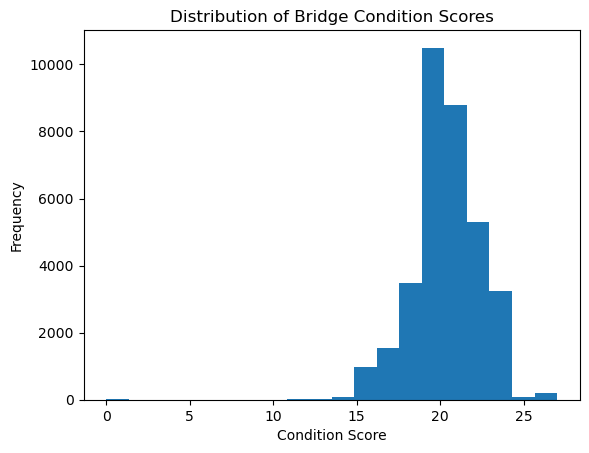

In [56]:
plt.hist(df['Condition'], bins= 20)
plt.xlabel('Condition Score')
plt.ylabel('Frequency')
plt.title('Distribution of Bridge Condition Scores')
plt.show()

Bridge condition scores, according to the histogram, are closely concentrated between **15 and 24**, with a particularly high concentration around **19–22**. According to this distribution he majority of the bridges in the dataset are in good to excellent condition, with relatively few structures falling into the lower range **(below 15)**. The Texas Department of Transportation may have already decommissioned or renovated severely degraded bridges, as indicated by the lack of low end rankings.

The narrow spread and high central tendency **(mean 20.3, SD 2.0)** confirm low variability in bridge conditions. This consistency suggests that the sampled bridges' structural integrity is typically robust and that the state's maintenance initiatives are effective.



---
### Simplifying Bridge Material and Design Categories

A number of **Material** and **Design** types with relatively few entries (such as *Timber, Masonry, Suspension*) were present in the original dataset. According to the examination `Timber` bridges made up just 465 items, or less than 2% of the entire dataset while suspension and masonry were even less common. This also applies to the design of arches, trusses, and frames. These smaller groups were combined into a single **‘Other’** category to facilitate the analysis. 

Since their regression coefficients would be computed from extremely small samples, including such uncommon categories would increase model complexity and decrease statistical reliability. independent modelling is not feasible, even though timber bridges may show unique deterioration patterns as a result of material attributes. Future studies that concentrate exclusively on heritage or rural bridges, however, might separate these kinds for more concentrated research.

After simplifying:
- The **Material** column was reduced to: *Concrete, Steel, Other*
- The **Design** column was reduced to: *Beam, Slab, Other*


In [57]:
df['Material'].value_counts()

Material
Concrete    27123
Steel        6637
Timber        465
Other          48
Masonry        13
Name: count, dtype: int64

In [58]:
df['Design'].value_counts()

Design
Beam          28324
Slab           4340
Other          1240
Arch            159
Truss           137
Frame            68
Movable          13
Suspension        5
Name: count, dtype: int64

In [59]:
df['Material_simple'] = df['Material'].replace({'Timber': 'Other', 'Masonry': 'Other'})

df['Design_simple'] = df['Design'].replace({'Arch': 'Other', 'Truss': 'Other', 'Frame': 'Other', 'Movable': 'Other', 'Suspension': 'Other'})

print(df['Material_simple'].value_counts())
print(df['Design_simple'].value_counts())

        

Material_simple
Concrete    27123
Steel        6637
Other         526
Name: count, dtype: int64
Design_simple
Beam     28324
Slab      4340
Other     1622
Name: count, dtype: int64


C:\Users\olszt\AppData\Local\Temp\ipykernel_22444\157731124.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Material_simple'] = df['Material'].replace({'Timber': 'Other', 'Masonry': 'Other'})
C:\Users\olszt\AppData\Local\Temp\ipykernel_22444\157731124.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['Design_simple'] = df['Design'].replace({'Arch': 'Other', 'Truss': 'Other', 'Frame': 'Other', 'Movable': 'Other', 'Suspension': 'Other'})


### Calculating Bridge Age and Removing Outliers

By deducting the year of construction from 2019 (most recent complete year) , a new variable **Age** was generated in order to examine the association between bridge age and condition.

Although removing bridges designated as *Historic* could have been an alternate strategy, doing so would run the danger of excluding reliable data points that are still in use. Filtering by **Age** instead offers a more data driven and objective method of locating possible outliers.

The histogram below shows a distinct concentration of bridges built between 1960 and 2020, which corresponds with Texas's major periods of infrastructure investment.Buildings constructed prior to 1960 are quite uncommon and may have undergone considerable rebuilding or adhere to antiquated construction standards, which makes them less reflective of the current bridge network.

Extreme outliers were eliminated by applying a **100 year age constraint** (1919-2019) to guarantee analytical focus on the operating stock of modern bridges. By doing this, the great majority of pertinent data is preserved, but a few very old, unusual bridges are left out, whose state patterns might not accurately represent modern maintenance and design techniques.

After filtering:
- The average bridge age is around **37 years**, with most bridges between **17–54 years old**.
- This provides a more realistic dataset for further statistical analysis.



C:\Users\olszt\AppData\Local\Temp\ipykernel_22444\2522089424.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


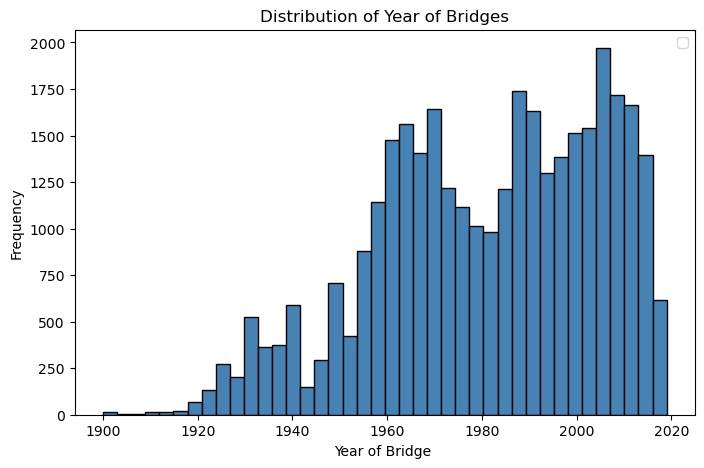

In [60]:
plt.figure(figsize=(8,5))
plt.hist(df['Year'], bins=40, color='steelblue', edgecolor='black')
plt.title('Distribution of Year of Bridges')
plt.xlabel('Year of Bridge ')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [61]:
df['Age'] = 2019- df['Year']
df['Age'].describe()

count    34286.000000
mean        37.502917
std         23.860336
min          0.000000
25%         17.000000
50%         34.000000
75%         55.000000
max        119.000000
Name: Age, dtype: float64

In [62]:
df= df[df['Age'] <=100]

df['Age'].describe()

count    34215.000000
mean        37.355955
std         23.664217
min          0.000000
25%         17.000000
50%         34.000000
75%         54.000000
max        100.000000
Name: Age, dtype: float64

---
## Exploratory Analysis – Variable Overview and Visualisation Choices

### Summary Statistics and Variable Selection

Using the `.describe()` method, descriptive statistics were produced for important numerical variables prior to investigating relationships. This gave a summary of the distribution, central tendency, and spread for **Truck Percentage**, **Average Daily Traffic**, **Condition**, and **Age**.
Furthermore, value counts were acquired for the simplified categorical variables **Material_simple** and **Design_simple**, which, after classifying smaller categories into "Other," display the frequency of each material and bridge design type. This is to guarantee balanced sample sizes across categories and prevent skewed comparisons.

Five predictors were chosen for further analysis based on their significance for data availability and bridge integrity:

- **Age** – Older bridges may deteriorate over time, potentially lowering their condition scores.
- **AverageDaily** – Represents daily traffic volume, which may contribute to structural wear.
- **Trucks Percentage** – Shows the influence of heavy vehicles on bridge, which can hinder codition scores over time.
- **Material_simple** – Reflects the type of construction material, which influences durability.
- **Design_simple** – Describes the structural design, which may impact overall performance and maintenance needs.


These variables allow for a balanced analysis of the factors influencing bridge condition because they capture both **structural** and **usage** aspects.



In [63]:
df[['Condition', 'Age', 'AverageDaily', 'Trucks_percent',]].describe()

,Condition,Age,AverageDaily,Trucks_percent
count,34192.000000,34215.000000,34215.000000,34215.000000
mean,20.311067,37.355955,11642.862429,8.594067
std,1.986011,23.664217,24252.911042,10.351341
min,0.000000,0.000000,0.000000,0.000000
25%,19.000000,17.000000,330.000000,0.000000
50%,21.000000,34.000000,3290.000000,5.000000
75%,22.000000,54.000000,11870.000000,13.000000
max,27.000000,100.000000,543000.000000,99.000000


In [64]:
print(df['Material_simple'].value_counts(), "\n")
print(df['Design_simple'].value_counts())

Material_simple
Concrete    27087
Steel        6604
Other         524
Name: count, dtype: int64 

Design_simple
Beam     28299
Slab      4333
Other     1583
Name: count, dtype: int64


### Choice of Visualisations

For the continuous variables **Age**, **Average Daily Traffic**, and **Trucks Percentage**, **Scatter Plots** were selected in order to depict potential trends, correlations, and outliers in the data. This aids in determining if improvements in these numerical predictors are associated with higher or lower bridge condition scores.

The distribution of condition scores for the categorical variables **Material_simple** and **Design_simple** was compared using **boxplots**. The variety between material and design kinds as well as variations in median condition are obviously displayed by this method.

Together, these plots offer a thorough and understandable picture of the ways in which numerical and categorical factors may affect bridge condition, laying the groundwork for a more in depth examination in the following section.

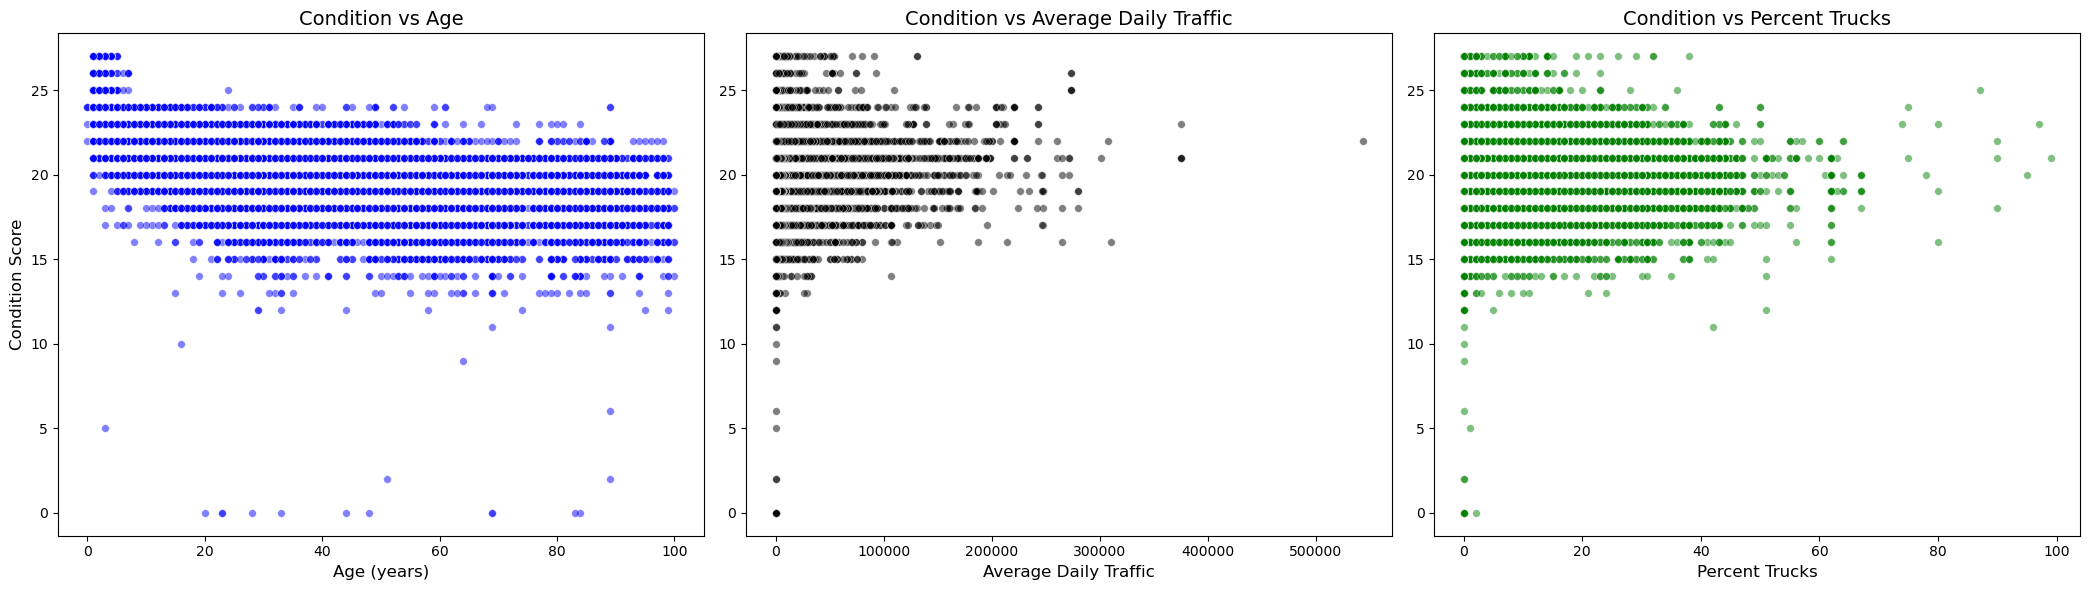

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(21, 6))


sns.scatterplot(data=df, x='Age', y='Condition', ax=axes[0], s=30, alpha=0.5, color='blue')
axes[0].set_title('Condition vs Age', fontsize=14)
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Condition Score', fontsize=12)


sns.scatterplot(data=df, x='AverageDaily', y='Condition', ax=axes[1], s=30, alpha=0.5, color='black')
axes[1].set_title('Condition vs Average Daily Traffic', fontsize=14)
axes[1].set_xlabel('Average Daily Traffic', fontsize=12)
axes[1].set_ylabel('')


sns.scatterplot(data=df, x='Trucks_percent', y='Condition', ax=axes[2], s=30, alpha=0.5, color='green')
axes[2].set_title('Condition vs Percent Trucks', fontsize=14)
axes[2].set_xlabel('Percent Trucks', fontsize=12)
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()

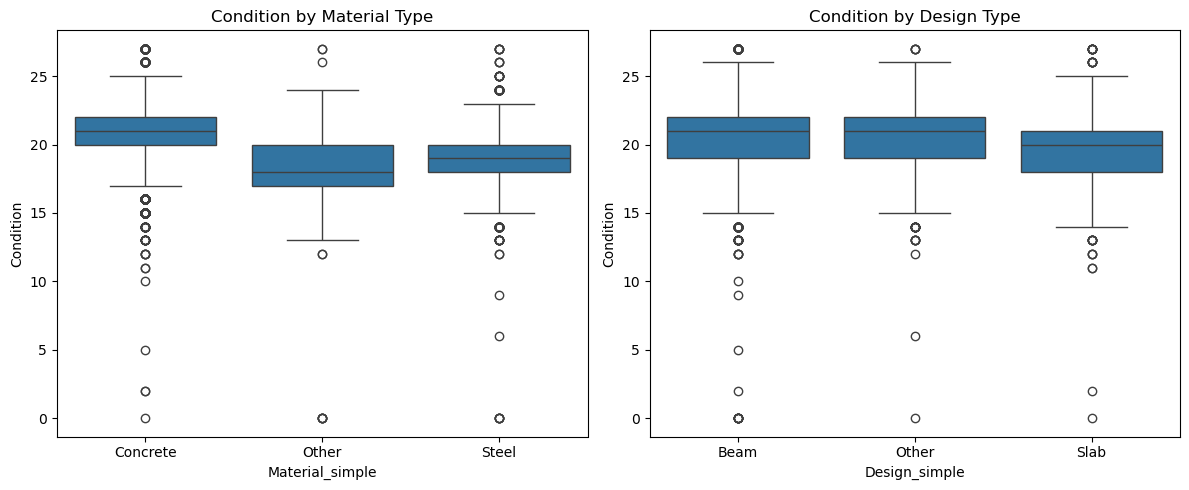

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=df, x='Material_simple', y='Condition', ax=axes[0])
axes[0].set_title('Condition by Material Type')

sns.boxplot(data=df, x='Design_simple', y='Condition', ax=axes[1])
axes[1].set_title('Condition by Design Type')

plt.tight_layout()
plt.show()


## Analysis of Plots

### **Condition versus Age:**
The scatter plot shows the age related variation in bridge condition scores.
There is a noticeable downward trend, with older bridges often having lower condition scores, signifying slow degradation over time. The distribution of points, however, demonstrates that age is not the only factor that determines condition; some older bridges are still in rather good condition, most likely as a result of regular upkeep or fixing efforts.

The majority of the bridges in this dataset appear to be within a conventional service life range, based on the concentration of points between **20 and 60 years**. The notion that structural ageing is a significant factor impacting bridge performance is supported by the fact that the few bridges older than 80 years typically exhibit considerably poorer condition scores.

The visualisation's overall findings support the **negative relationship between age and condition**, which is consistent with engineering predictions that bridges' structural integrity tends to deteriorate with age.

### **Condition vs Average Daily Traffic:**
The figure looks at whether weaker bridge conditions are linked to higher traffic volumes. Although bridges with very high traffic volumes tend to cluster around middle to lower condition ratings **(19-22)**, there doesn't seem to be **a strong linear relationship**. This implies that other elements like maintenance and design probably have a greater influence on progressive deterioration, even though traffic stress may also play a part.

### **Condition vs Trucks Percentage:**
The scatter plot emphasises the percentage of large trucks that use each bridge.
Bridges exposed to a higher percentage of truck traffic typically have slightly lower condition scores, indicating a **slight negative trend**. This makes sense because over time, larger vehicles put more strain on structural elements.

 Overall, both visualisations reveal that **traffic factors alone do not entirely explain variations in bridge condition**, but that the connection between truck percentage and the condition of bridges is more pronounced.

---

### 2. Categorical Predictors – Boxplots

**Condition by Material Type:**
The higher median condition of concrete bridges reflects the material’s resilience and widespread use in Texas’s bridge network. Steel bridges display greater variability and slightly lower medians, suggesting more diverse maintenance histories and susceptibility to corrosion. With the 'Other' category lying in the middle. The wider range of values in steel bridges raises the possibility that they are more likely to deteriorate or have more variation in their maintenance or construction quality.

**Condition by Design Type:**
Consistent structural performance is indicated by beam bridges, which have the highest median condition score and the least variability. While the "Other" group exhibits greater variability, indicating varied design attributes and performance outcomes, slab bridges exhibit a somewhat lower median condition and a larger variation.

---

Overall, these visualisations indicate that **bridge age, material type, and design** have the greatest effects on structural condition, whereas **traffic volume and percentage of trucks** have less effect but still significant relationships that call for more research in the regression stage.

In [67]:
df[['Age', 'AverageDaily', 'Trucks_percent']].corr()

,Age,AverageDaily,Trucks_percent
Age,1.000000,-0.056697,0.222063
AverageDaily,-0.056697,1.000000,0.023008
Trucks_percent,0.222063,0.023008,1.000000


In [68]:
pd.crosstab(df['Material_simple'], df['Design_simple'])

Design_simple,Beam,Other,Slab
Material_simple,,,
Concrete,21694,1060,4333
Other,464,60,0
Steel,6141,463,0


### Relationships Between Predictors

To understand how the predictor variables relate to one another, both a correlation matrix (for numerical variables) and a cross-tabulation (for categorical variables) were examined.

The **correlation matrix** indicates very weak relationships between the three numerical predictors — *Age*, *Average Daily Traffic*, and *Percent Trucks*.

- The correlation between **Age** and **Average Daily Traffic** is slightly negative (-0.05), suggesting that older bridges are not necessarily located on busier routes.
  
- The small positive correlation (0.22) between **Age** and **Percent Trucks** implies that older bridges may experience slightly higher proportions of heavy vehicles, but this relationship remains weak.

- The extremely low correlation (0.02) between **Average Daily Traffic** and **Percent Trucks** suggests that total traffic volume and truck percentage are largely independent.

- Overall, the low correlation values suggest **minimal multicollinearity**, meaning these variables can be treated as largely independent in subsequent analysis.
---

When comparing `Material_simple` with `Design_simple`, the **cross-tabulation** shows how the categorical variables overlap.

- The majority of **concrete** bridges have **beam** or **slab** designs.

- Nearly all bridges made of steel are of the **beam** variety, with the **other** materials being used sparingly in various designs.

These findings demonstrate that, even if some material and design combinations are more prevalent, there is enough heterogeneity to support the inclusion of both variables as independent predictors in the regression model.



---
### Exploring Categorical vs Numerical Relationships

This section examines how the percentage of heavy vehicles varies across various bridge designs by comparing a **numerical variable** `Trucks_percent` with a **categorical variable** `Design_simple`.

It is possible to determine whether some design types are more frequently exposed to heavy truck traffic by looking at categorical and numerical correlations. This could have an impact on the structural state and deterioration patterns over the long run.

Two additional comparisons were made:

- **Bridge Age by Material Type:**
-  **Average Daily Traffic by Bridge Design:**

Bridge age and traffic exposure are two variables that may have an indirect impact on structural state, and this research helps uncover how material and design decisions may affect these parameters.


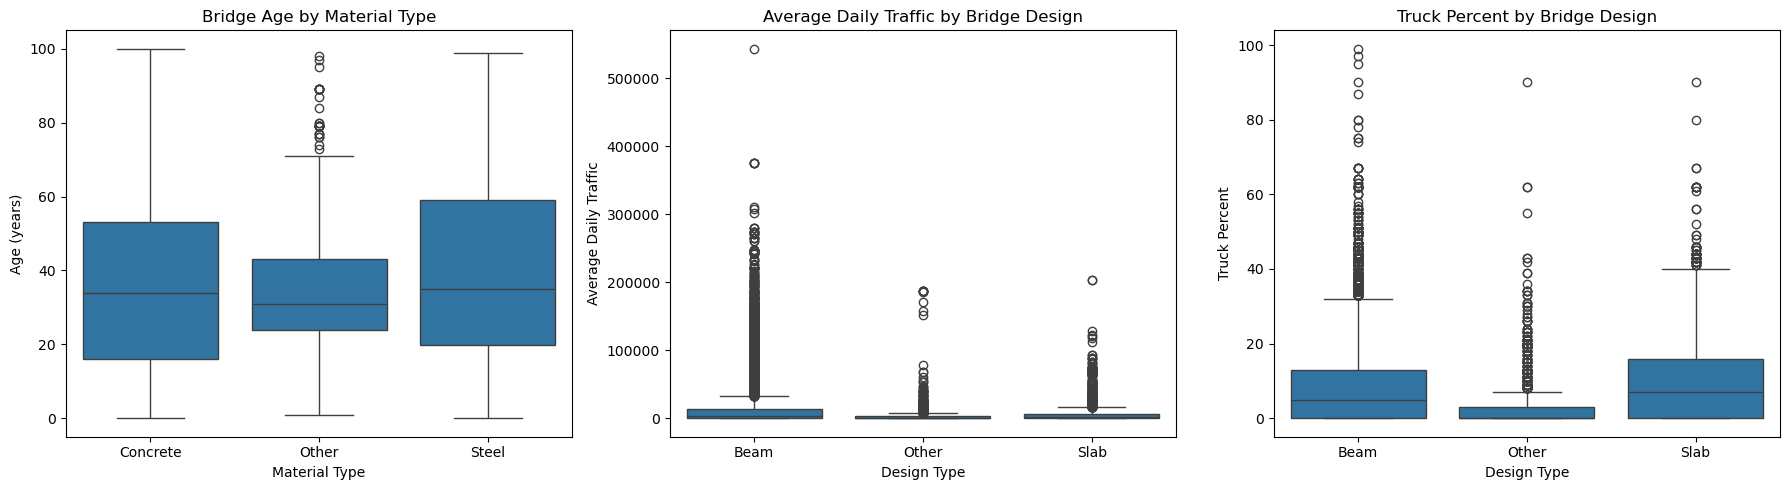

In [69]:
Fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.boxplot(data=df, x='Material_simple', y='Age', ax=axes[0])
axes[0].set_title('Bridge Age by Material Type', fontsize=12)
axes[0].set_xlabel('Material Type')
axes[0].set_ylabel('Age (years)')


sns.boxplot(data=df, x='Design_simple', y='AverageDaily', ax=axes[1])
axes[1].set_title('Average Daily Traffic by Bridge Design', fontsize=12)
axes[1].set_xlabel('Design Type')
axes[1].set_ylabel('Average Daily Traffic')


sns.boxplot(data=df, x='Design_simple', y='Trucks_percent', ax=axes[2])
axes[2].set_title('Truck Percent by Bridge Design', fontsize=12)
axes[2].set_xlabel('Design Type')
axes[2].set_ylabel('Truck Percent')

plt.tight_layout()
plt.show()

### Analysis of Categorical VS Numerical Relationships

- **Bridge Age by Material Type:**
The greatest age range is seen in concrete bridges, suggesting that they have been in service for many years. While constructions constructed of other materials are more numerous and varied, perhaps reflecting experimental or transitory designs, steel bridges are often a little newer.

- **Average Daily Traffic by Bridge Design:**
Compared to slab bridges, beam bridges typically handle larger daily traffic loads, indicating that they are more frequently utilised on important transportation routes. Beam bridges are used in both high and medium traffic situations, as seen by the wide variation in traffic.

- **Truck Percent by Bridge Design:**
Although slab bridges exhibit somewhat greater variability, median truck percentages for beam and slab bridges are comparable. This might be a reflection of how different design types are assigned to highways that see higher traffic.

Overall, these visualisations show that **material types and bridge design are connected with modest but important changes in traffic characteristics and age**. Their inclusion as possible predictors in the ensuing regression analysis is supported by this realisation.

---

### Handling Missing Data

The **Condition** variable was the only one with missing values; just 22 in the overall dataset were impacted. Any imputation (e.g., using median or mode) could introduce artificial bias and skew the results of future analyses, as this variable is the primary dependent measure.

These rows were **safely eliminated using `dropna()`** due to the minimal percentage of missing entries compared to the size of the entire dataset.This method improves overall data integrity without sacrificing sample size or representativeness by guaranteeing that all remaining data points have accurate and comprehensive information for the regression stage.

In [70]:
print(df[['Age', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Condition']].dtypes)

print(df[['Age', 'AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Condition']].isnull().sum())


Age                  int64
AverageDaily         int64
Trucks_percent     float64
Material          category
Design            category
Condition          float64
dtype: object
Age                0
AverageDaily       0
Trucks_percent     0
Material           0
Design             0
Condition         23
dtype: int64


In [71]:
df = df.dropna(subset=['Condition'])
print(df[['Condition']].isnull().sum())

Condition    0
dtype: int64


---
## Regression Modelling

A multiple linear regression model was developed to evaluate how `Age`, `Average Daily Traffic`, `Truck Percentage`, `Material Type`, and `Design`Type influence Bridge Condition.

Prior to model fitting, all categorical variables were numerically encoded and all predictors were standardised to ensure compatibility and to mitigate the influence of differing measurement scales. This allows coefficients to be interpreted in a comparable way and prevents dominance of variables measured in larger units.


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


df_encoded = pd.get_dummies(df, columns=['Material_simple', 'Design_simple'], drop_first=True)


X = df_encoded[['Age', 'AverageDaily', 'Trucks_percent',
'Material_simple_Steel', 'Material_simple_Other',
'Design_simple_Other', 'Design_simple_Slab']]

y = df_encoded['Condition']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


---
### Model Fitting
All predictors were standardised using `StandardScaler` to put them on a same scale once the categorical variables had been encoded.
By doing this step, the regression coefficients are shielded from the disproportionate influence of predictors evaluated in various units.

**LinearRegression** from `scikit-learn` was then used to fit the model. This method calculates coefficients that minimise the sum of squared errors between the actual and projected bridge condition values.

In [73]:
from sklearn.preprocessing import StandardScaler


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()


reg = LinearRegression()
reg.fit(X_scaled, y_scaled)

y_pred_scaled = reg.predict(X_scaled)

print("Intercept:", reg.intercept_)
print("Coefficients:", reg.coef_)

Intercept: -3.627608139823237e-16
Coefficients: [-0.57985435 -0.00891464  0.02710283 -0.271922   -0.16632025  0.01323553
 -0.01205464]


---
### Model Evaluation

Two key metrics were used to assess the model’s performance:

**Mean Squared Error (MSE)**: measures the average squared difference between observed and predicted condition values. Lower MSE indicates higher accuracy.

**R² (Coefficient of Determination)**: represents the proportion of variance in bridge condition explained by the predictors. Higher values indicate stronger explanatory power.

These metrics together indicate how well the model generalises and the extent to which it captures variability in bridge condition.

In [74]:
from sklearn.metrics import mean_squared_error, r2_score


y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = y.values 


mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R-squared: {r2:.3f}")

Mean Squared Error: 2.162
R-squared: 0.452


---
### Residual Diagnostics

**Motivation:**
To ensure the regression assumptions were met, the residuals (differences between actual and predicted values) were examined for normality, homoscedasticity, and independence.

**Method:**
Three diagnostic plots were generated:
1. A histogram of residuals to assess normality
2. Residuals vs predicted values to evaluate homoscedasticity
3. Predicted vs actual condition values to assess model fit

**Discussion:**
The histogram indicates a roughly bell-shaped distribution, suggesting that residuals are approximately normal.
The residuals vs predicted scatter shows that most points are centred around zero, with some heteroscedasticity at higher predicted conditions.
The predicted vs actual plot reveals a fairly linear trend, though underestimation is visible for bridges in better condition.
Overall, these diagnostics confirm that the model performs reasonably well, though some non-linearity may remain.


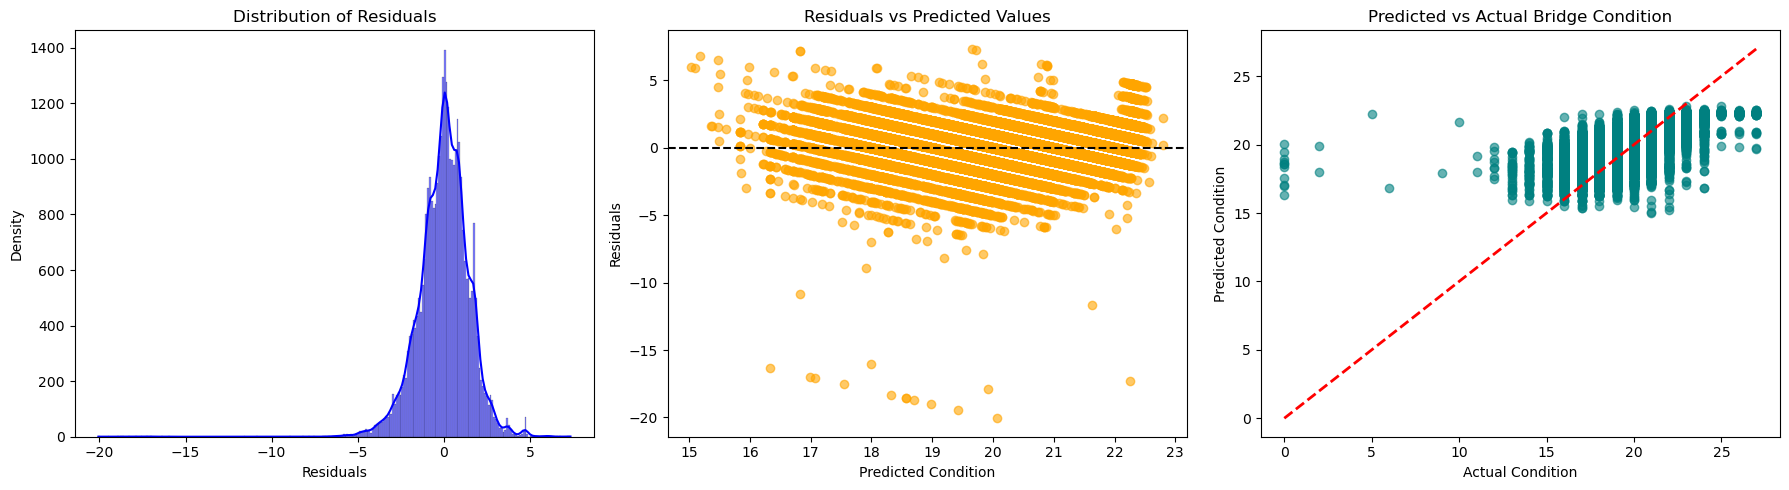

In [75]:
residuals = y_true - y_pred


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.histplot(residuals, kde=True, color='blue', ax=axes[0])
axes[0].set_title("Distribution of Residuals")
axes[0].set_xlabel("Residuals")
axes[0].set_ylabel("Density")


axes[1].scatter(y_pred, residuals, alpha=0.6, color='orange')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title("Residuals vs Predicted Values")
axes[1].set_xlabel("Predicted Condition")
axes[1].set_ylabel("Residuals")


axes[2].scatter(y_true, y_pred, alpha=0.6, color='teal')
axes[2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
color='red', linestyle='--', linewidth=2)
axes[2].set_title("Predicted vs Actual Bridge Condition")
axes[2].set_xlabel("Actual Condition")
axes[2].set_ylabel("Predicted Condition")


plt.tight_layout()
plt.show()

---
### Coefficient Interpretation

The following regression coefficients show the magnitude and direction of each predictor's impact on bridge condition:

**Positive coefficients** indicate that *better* bridge condition is linked to an increase in the predictor.
**Negative coefficients** indicate that a *deterioration* in condition is correlated with an increase in the predictor.

As an illustration, **Age** exhibits a significant negative coefficient, indicating that older bridges typically have worse conditions.
The effects of **Material Type** and **Design Type** also differ, indicating that greater structural performance is linked to specific construction features.


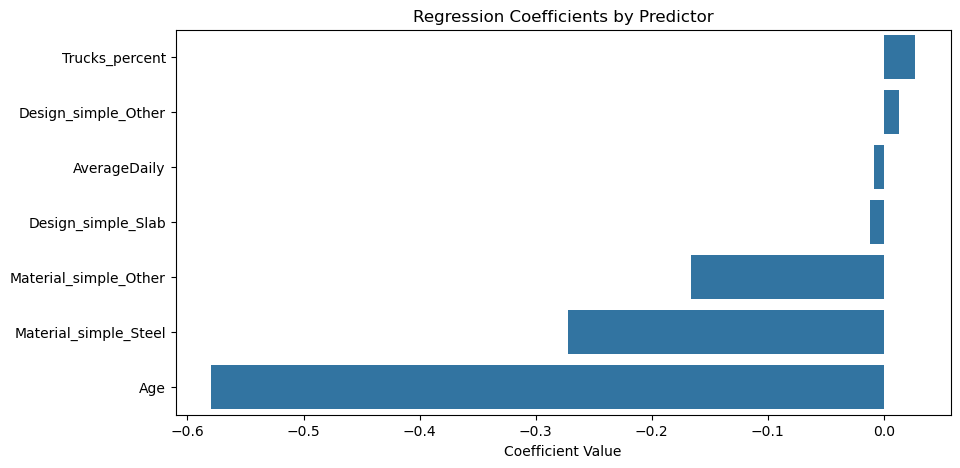

,Predictor,Coefficient
2,Trucks_percent,0.027103
5,Design_simple_Other,0.013236
1,AverageDaily,-0.008915
6,Design_simple_Slab,-0.012055
4,Material_simple_Other,-0.166320
3,Material_simple_Steel,-0.271922
0,Age,-0.579854


In [76]:
coeff_df = pd.DataFrame({
'Predictor': X.columns,
'Coefficient': reg.coef_
}).sort_values(by='Coefficient', ascending=False)


plt.figure(figsize=(10,5))
sns.barplot(x='Coefficient', y='Predictor', data=coeff_df)
plt.title('Regression Coefficients by Predictor')
plt.xlabel('Coefficient Value')
plt.ylabel('')
plt.show()

coeff_df



### Summary of Regression Findings

The patterns found during the exploratory phase are quantitatively supported by the regression analysis.
The greatest and most reliable negative predictor of bridge condition among all the variables was **Age**.
The fact that older bridges typically have lower condition scores, suggesting natural deterioration over time, is confirmed by this, which is consistent with the previous boxplots and correlations.

The model does a fair job of capturing the general pattern, as evidenced by the scatter plot of **predicted condition vs actual condition**, which indicates that the predicted bridge condition values follow a fairly linear trend with the actual values.
For higher condition scores, however, the vertical dispersion surrounding the red dashed line points to some underestimation and forecast mistakes.
This is consistent with the modest R2 value (about 0.45), which indicates that the model partially, but not entirely, explains the variation in bridge condition.

Although usage intensity contributes to wear, its direct impact on condition is less obvious than structural age, according to the **traffic related variables**:  *Average Daily Traffic* and *Truck Percentage*  which displayed weaker coefficients.
This could suggest that the effects of excessive vehicle traffic are somewhat lessened by good maintenance and design.

Additionally, categorical elements like **Material Type** and **Design Type** were significant.
In comparison to the reference group (*Concrete*), bridges constructed of *Steel* and *Other materials* tended to have somewhat lower condition scores, suggesting possible variations in durability or maintenance needs.
In a similar vein, differences within design categories (such as *Beam*, *Slab*, and *Other*) imply that design selection affects how structures age and react to stress.

The model satisfies the fundamental presumptions of linear regression, as demonstrated by residual diagnostics, which revealed that errors were roughly normally distributed and randomly distributed about zero.
The residual plot does, however, show considerable asymmetry, which raises the possibility of unmeasured factors or nonlinear effects.

The model's **R2** value was around **0.45**, indicating that the predictors included in it can account for about 45% of the variation in bridge condition.
For infrastructure data from the real world, when numerous environmental and external elements are not recorded, this indicates a moderate amount of explanatory power.



---
## Conclusion
Deterioration over time continues to be the primary predictor of structural performance, as evidenced by the statewide bridge dataset analysis, which shows that structural age is the primary factor determining total bridge condition. Secondary but significant effects are also contributed by material type and design form: beam-type structures exhibit consistent structural integrity across a range of use levels, whereas concrete bridges typically maintain higher condition ratings.

The average daily traffic and the percentage of trucks, on the other hand, show only slight effects, indicating that Texas's modern engineering and maintenance standards are successfully reducing load related deterioration. These factors are still crucial for predicting future wear, though, especially as the use of heavy vehicles keeps increasing.

About 45% of the variance in bridge condition was explained by the regression model, suggesting a respectable degree of explanatory power for actual infrastructure data. Although the residual analysis verified that linear assumptions were generally followed, a small asymmetry suggests that unmeasured external factors, including the frequency of maintenance, exposure to the environment, or the time of construction, may have an additional impact on condition outcomes.

These results underscore the strategic significance for the Texas Department of Transportation of giving inspection and renewal of ageing bridges particularly those older than 60 years. Future analyses that incorporate maintenance logs, material fatigue data, and environmental exposure measurements could improve predicted accuracy and allow for more focused infrastructure management throughout the state.
